# Robust BIM microchip production problem

In [1]:
# install dependencies and select solver
!pip install -q amplpy numpy pandas matplotlib

SOLVER_MILP = "highs"  ## highs, scip, cbc, mosek, gurobi
SOLVER_NLO = "ipopt"
SOLVER_MINLO = "bonmin"  ## mosek, scip, gurobi, knitro

In [2]:
from amplpy import AMPL, tools

ampl = tools.ampl_notebook(
    modules=["coin", "highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register notebook magics

Please provide a valid license UUID. You can use a free https://ampl.com/ce license.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Original BIM production planning model

The full description of the BIM production problem, can be found [here](../02/bim.ipynb). The resulting optimization problem was the following LP:

$$
\begin{array}{rrcrcl}
\max    & 12x_1 & + & 9x_2               \\
\text{s.t.}    &   x_1 &   &      & \leq & 1000 \\
        &       &   &  x_2 & \leq & 1500 \\
        &   x_1 & + &  x_2 & \leq & 1750 \\
        &  4x_1 & + & 2x_2 & \leq & 4800 \\
        &   x_1 & , &  x_2 & \geq & 0.
\end{array}
$$

In [4]:
%%ampl_eval

set CHIPS;

param profits{CHIPS};
param copper{CHIPS};

var x{CHIPS} >= 0;

maximize Profit: sum {c in CHIPS} profits[c] * x[c];

s.t. Silicon: x['logic'] <= 1000;
s.t. Germanium: x['memory'] <= 1500;
s.t. Plastic: sum {c in CHIPS} x[c] <= 1750;
s.t. Copper: sum {c in CHIPS} copper[c] * x[c] <= 4800;

In [5]:
chips = ["logic", "memory"]
profits = {"logic": 12, "memory": 9}
copper = {"logic": 4, "memory": 2}

ampl.set["CHIPS"] = chips
ampl.param["profits"] = profits
ampl.param["copper"] = copper

ampl.option["solver"] = SOLVER_MILP
ampl.solve()

x = ampl.get_variable("x").get_values().to_dict()

print(f"x = ({x})")
print(f'optimal value = {ampl.obj["Profit"].value():.2f}')

HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17700
2 simplex iterations
0 barrier iterations
x = ({'logic': 650.0, 'memory': 1100.0})
optimal value = 17700.00


In [6]:
def ShowDuals(ampl):
    import fractions

    # display all duals
    print("The dual variable corresponding to:\n")
    for name, con in ampl.get_constraints():
        print(
            "- the constraint on",
            name,
            "is equal to ",
            str(fractions.Fraction(con.dual())),
        )


ShowDuals(ampl)

The dual variable corresponding to:

- the constraint on Copper is equal to  3/2
- the constraint on Germanium is equal to  0
- the constraint on Plastic is equal to  6
- the constraint on Silicon is equal to  0


## Robust BIM production planning models

Suppose now that there is uncertainty affecting the microchip production at BIM. Specifically, the company notices that the amount of copper needed for the two types of microchips is not _exactly_ 4 and 2 gr, but varies due to some external factors affecting the production process. How does this uncertainty affect the optimal production plan?

To get a feeling for what happens, let us first perform some simulations and data analysis on them. We start by simulating a sample of $n=2000$ observed copper consumption pairs for the production of `f` logic chips and `g` memory chips. The amounts vary around the original values, 4 gr and 2 gr, respectively, according to two independent lognormal distributions.

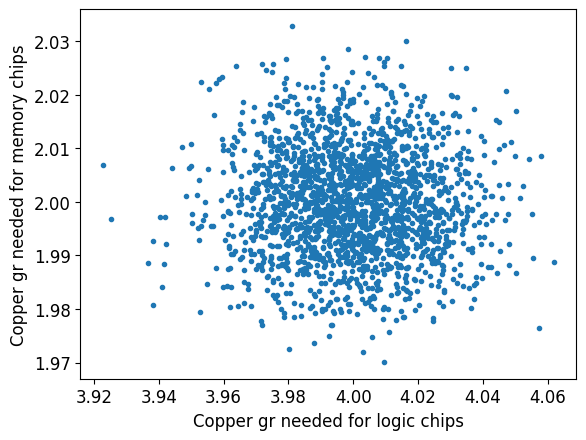

In [7]:
plt.rcParams.update({"font.size": 12})

seed = 0
rng = np.random.default_rng(seed)
n = 2000

f = rng.lognormal(np.log(4.0), 0.005, n)
g = rng.lognormal(np.log(2.0), 0.005, n)

plt.figure()
plt.plot(f, g, ".")
plt.xlabel("Copper gr needed for logic chips")
plt.ylabel("Copper gr needed for memory chips")
plt.show()

### Box uncertainty for copper consumption

A very simple and somehow naive uncertainty set can be the minimal box that contains all the simulated data.

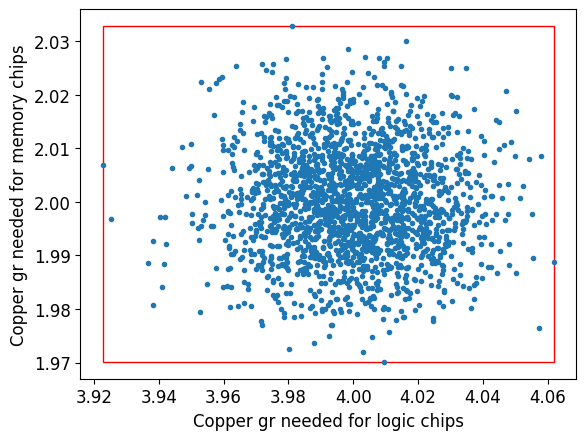

Lower bounds {'logic': 3.922766922829344, 'memory': 1.9701110863753781}
Upper bounds {'logic': 4.061793174956137, 'memory': 2.0328386701386703}


In [8]:
plt.figure()
plt.plot(f, g, ".")
currentAxis = plt.gca()
currentAxis.add_patch(
    patches.Rectangle(
        (min(f), min(g)),
        max(f) - min(f),
        max(g) - min(g),
        fill=False,
        color="r",
    )
)
plt.xlabel("Copper gr needed for logic chips")
plt.ylabel("Copper gr needed for memory chips")
plt.show()

# calculate the upper and lower bounds for each uncertain parameter
lower = {"logic": min(f), "memory": min(g)}
upper = {"logic": max(f), "memory": max(g)}
print("Lower bounds", lower)
print("Upper bounds", upper)

Using this empirical box uncertainty set, we can consider the following robust variant of their optimization model:

$$
\begin{array}{rrcrcl}
\max    &  12 x_1 & + &   9 x_2               \\
\text{s.t.}    &     x_1 &   &         & \leq & 1000 \\
        &         &   &     x_2 & \leq & 1500 \\
        &     x_1 & + &     x_2 & \leq & 1750 \\
        & z_1 x_1 & + & z_2 x_2 & \leq & 4800 & \forall \ell \leq a \leq u \\
        &     x_1 & , &     x_2 & \geq & 0    \\
\end{array}
$$

The above model has an infinite number of constraints, one for every realization of the uncertain coefficients $z$. However, using linear duality, we can deal with this and obtain a robustified LP that we can solve. 

### Robust counterpart of box uncertainty

The first thing to notice is that the copper consumption is modeled by constraints that are equivalent to bounding the following optimization problem:
    
$$
\begin{array}{rrr}
\max    & x_1 z_1 + x_2 z_2 & \leq 4800 \\
\text{s.t.}    & \ell \leq z \leq u 
\end{array}
$$

or

$$
\begin{array}{rrr}
\max    & x_1 z_1 + x_2 z_2 & \leq 4800 \\
\text{s.t.}    & z \leq u \\
        & -z \leq -\ell.
\end{array}
$$

Now we use linear duality to realize that the above is equivalent to:
 
$$
\begin{array}{rrr}
\min    & u y  - \ell w & \leq 4800 \\
\text{s.t.}    & y - w = x \\
        & y \geq 0, w \geq 0
\end{array}
$$
    
and the constraint imposed by the last problem is equivalent to:

$$
\begin{array}{rrl}
   & u y  - \ell w & \leq 4800 \\
   & y - w & = x \\
   & y \geq 0, w \geq 0
\end{array}
$$

The only thing we need to do is add the new auxiliary variables and constraints to the original model and implement them in AMPL.

In [9]:
%%writefile BIM_robust_box.mod

set CHIPS;

param profits{CHIPS};
param copper{CHIPS};

var x{CHIPS} >= 0, integer;

maximize Profit: sum {c in CHIPS} profits[c] * x[c];

s.t. Silicon: x['logic'] <= 1000;
s.t. Germanium: x['memory'] <= 1500;
s.t. Plastic: sum {c in CHIPS} x[c] <= 1750;

param lower{CHIPS};
param upper{CHIPS};
    
var y{CHIPS} >= 0;
var w{CHIPS} >= 0;

s.t. RobustCopper:
    sum {c in CHIPS} (upper[c]*y[c] - lower[c]*w[c]) <= 4800;
s.t. PerVariable{c in CHIPS}:
    x[c] == y[c] - w[c];


Overwriting BIM_robust_box.mod


In [10]:
def BIMWithBoxUncertainty(lower, upper, int_x=False):
    ampl = AMPL()
    ampl.read("BIM_robust_box.mod")

    ampl.set["CHIPS"] = chips
    ampl.param["profits"] = profits
    ampl.param["copper"] = copper

    ampl.param["lower"] = lower
    ampl.param["upper"] = upper

    if not int_x:
        ampl.eval("let {i in CHIPS} x[i].relax := 1;")

    ampl.option["solver"] = SOLVER_MILP
    ampl.solve()

    return ampl


ampl = BIMWithBoxUncertainty(lower, upper)

x = ampl.get_variable("x").get_values().to_dict()
print(f"x = ({x})")
print(f'optimal value = {ampl.obj["Profit"].value():.2f}')

HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17587.20087
2 simplex iterations
0 barrier iterations
x = ({'logic': 612.4002900543649, 'memory': 1137.599709945635})
optimal value = 17587.20


We may want to impose the box uncertainty set to be symmetric with respect to the nominal values and just choose its width $\delta$. This leads to a different optimal robust solution.

In [11]:
# The parameter delta allows you to tune the amount of uncertainty.
# In particular, if you take delta=0, you obtain the same result as the nominal model.
delta = 0.05


def BIMWithSymmetricalBoxUncertainty(delta, int_x=False):
    lower = {chip: copper[chip] - delta for chip in chips}
    upper = {chip: copper[chip] + delta for chip in chips}
    return BIMWithBoxUncertainty(lower, upper, int_x)


ampl = BIMWithSymmetricalBoxUncertainty(delta)

x = ampl.get_variable("x").get_values().to_dict()
print(f"x = ({x})")
print(f'optimal value = {ampl.obj["Profit"].value():.2f}')

HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17568.75
2 simplex iterations
0 barrier iterations
x = ({'logic': 606.2499999999999, 'memory': 1143.75})
optimal value = 17568.75


### Integer solution variant

The original BIM model gave integer solutions, but not the robust version. If we need integer solutions then we should impose that to the nature of the variables, which in this case of _box uncertainty_ is easy to do since the model remains linear, although it will be mixed integer. 

In [12]:
ampl = BIMWithBoxUncertainty(lower, upper, True)

x = ampl.get_variable("x").get_values().to_dict()
print(f"x = ({x})")
print(f'optimal value = {ampl.obj["Profit"].value():.2f}')

HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17586
3 simplex iterations
1 branching nodes
x = ({'logic': 612.0000000000006, 'memory': 1137.999999999999})
optimal value = 17586.00


Let us see how the optimal solution behave as we vary the width of the box uncertainty set $\delta$ from 0 to 0.5. 

In [13]:
import pandas as pd

df = pd.DataFrame()
for delta in np.linspace(0, 0.5, 21):
    ampl = BIMWithSymmetricalBoxUncertainty(delta, True)
    x = ampl.get_variable("x").get_values().to_dict()
    results = [ampl.get_value("Profit")] + [x[str(i)] for i in chips]
    df.at[delta, "profit"] = results[0]
    df.at[delta, chips[0]] = results[1]
    df.at[delta, chips[1]] = results[2]
df

HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17700
2 simplex iterations
1 branching nodes
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17634
3 simplex iterations
1 branching nodes
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17568
3 simplex iterations
1 branching nodes
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17502
3 simplex iterations
1 branching nodes
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17436
3 simplex iterations
1 branching nodes
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17370
3 simplex iterations
1 branching nodes
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17304
3 simplex iterations
1 branching nodes
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17238
3 simplex iterations
1 branching nodes
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17175
2 simplex iterations
1 branching nodes
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17109
3 simplex iterations
1 branching nodes
HiGHS 1.5.

,profit,logic,memory
0.000,17700.0,650.0,1100.0
0.025,17634.0,628.0,1122.0
0.050,17568.0,606.0,1144.0
0.075,17502.0,584.0,1166.0
0.100,17436.0,562.0,1188.0
0.125,17370.0,540.0,1210.0
0.150,17304.0,518.0,1232.0
0.175,17238.0,496.0,1254.0
0.200,17175.0,475.0,1275.0
0.225,17109.0,453.0,1297.0


We can visualize how these quantities change as a function of $\delta$:

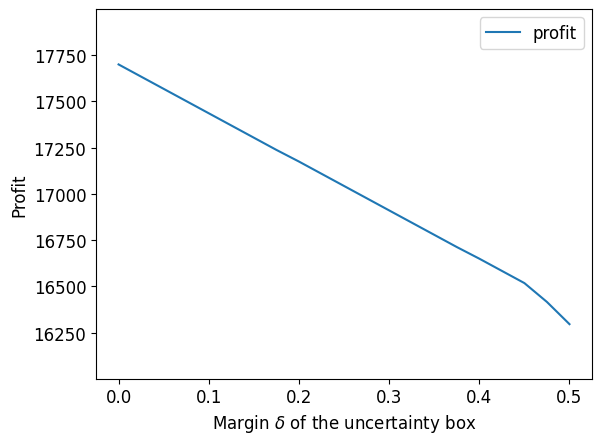

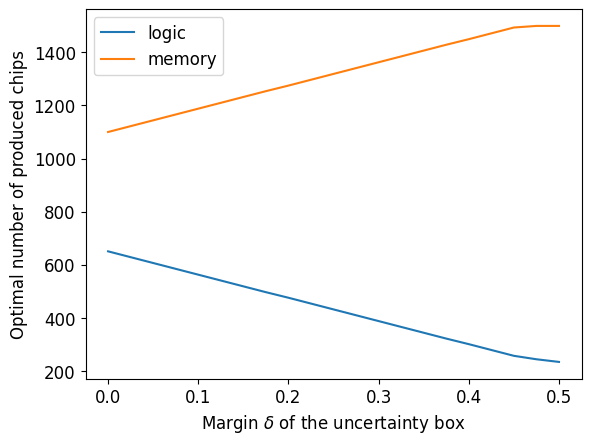

In [14]:
df[["profit"]].plot()
plt.ylim([16001, 17999])
plt.xlabel("Margin $\delta$ of the uncertainty box")
plt.ylabel("Profit")
plt.show()
df[["logic", "memory"]].plot()
plt.xlabel("Margin $\delta$ of the uncertainty box")
plt.ylabel("Optimal number of produced chips")
plt.show()

## Cardinality-constrained uncertainty set

Let us now make different assumptions regarding the uncertainty related to the copper consumption. More specifically, we now assume that each uncertain coefficient $z_j$ may deviate by at most $\pm \delta$ from the nominal value $\bar{z}_j$ but no more than $\Gamma$ will actually deviate.

$$
\begin{array}{rrcrcl}
\max    &  12 x_1 & + &   9 x_2               \\
\text{s.t.}    &     x_1 &   &         & \leq & 1000 \\
        &         &   &     x_2 & \leq & 1500 \\
        &     x_1 & + &     x_2 & \leq & 1750 \\
        & z_1 x_1 & + & z_2 x_2 & \leq & 4800 & \forall \, y \in \mathbb{R}^2 \,:\, z_j=\bar{z}_j+\delta y_j, \, \|y\|_\infty \leq 1, \, \|y\|_1\leq \Gamma \\
        &     x_1 & , &     x_2 & \geq & 0    \\
\end{array}
$$

### Robust counterpart of cardinality-constrained uncertainty
Lagrange duality yields the following modification to the problem as equivalent to the robust model stated above:

$$
\begin{array}{rrcrcrcrcrcrcl}
\max    &  12 x_1 & + &   9 x_2               \\
\text{s.t.}    &     x_1 &   &         & & & & & & & \leq & 1000 \\
        &         &   &     x_2 & & & & & & & \leq & 1500 \\
        &     x_1 & + &     x_2 & & & & & & & \leq & 1750 \\
        & \bar{z}_1 x_1 & + & \bar{z}_2 x_2 & + & \lambda\Gamma & + & t_1 & + & t_2 & \leq & 4800 \\
        &-\delta x_1 &   &         & + & \lambda & + & t_1 &   &     & \geq & 0 \\
        &         &   &-\delta x_2 & + & \lambda &   &     & + & t_2 & \geq & 0 \\
        &\delta x_1 &   &         & + & \lambda & + & t_1 &   &     & \geq & 0 \\
        &         &   &\delta x_2 & + & \lambda &   &     & + & t_2 & \geq & 0 \\
        &     x_1 & , &     x_2 & , & \lambda & , & t_1 & , & t_2 & \geq & 0    \\
\end{array}
$$

In [15]:
%%writefile BIM_robust_cardinality.mod

set CHIPS;

param profits{CHIPS};
param copper{CHIPS};

var x{CHIPS} >= 0, integer;

maximize Profit: sum {c in CHIPS} profits[c] * x[c];

s.t. Silicon: x['logic'] <= 1000;
s.t. Germanium: x['memory'] <= 1500;
s.t. Plastic: sum {c in CHIPS} x[c] <= 1750;

param Gamma;
param delta;
    
var t{CHIPS} >= 0;
var lam >= 0;

s.t. RobustCopper:
    sum {c in CHIPS} copper[c] * x[c]
        + Gamma * lam
        + sum {c in CHIPS} t[c]
        <= 4800;

s.t. UpRule{c in CHIPS}:
    t[c] >= delta * x[c] - lam;
s.t. DownRule{c in CHIPS}:
    t[c] >= -delta * x[c] - lam;


Overwriting BIM_robust_cardinality.mod


In [16]:
def BIMWithBudgetUncertainty(delta, gamma):
    ampl = AMPL()
    ampl.read("BIM_robust_cardinality.mod")

    ampl.set["CHIPS"] = chips
    ampl.param["profits"] = profits
    ampl.param["copper"] = copper

    ampl.param["delta"] = delta
    ampl.param["Gamma"] = gamma

    ampl.option["solver"] = SOLVER_MILP
    ampl.solve()

    return ampl


ampl = BIMWithBudgetUncertainty(0.01, 2)

x = ampl.get_variable("x").get_values().to_dict()
print(f"x = ({x})")
print(f'optimal value = {ampl.obj["Profit"].value():.2f}')

HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17673
4 simplex iterations
1 branching nodes
x = ({'logic': 641.0, 'memory': 1109.0})
optimal value = 17673.00


### Adversarial approach for the budgeted uncertainty set

Instead of adopting the approach of robust counterparts, we could also use the adversarial approach where we initially solve the problem for the nominal value of the data. Then, we iteratively search for scenarios that make the current solution violate the copper constraint, and pre-solve the problem to take this scenario into account. To do so, we need to slightly modify our problem formulation function to allow for many scenarios for the parameter $z$.

In [17]:
%%writefile BIM_robust_cardinality_adversarial.mod

set CHIPS;

param profits{CHIPS};
param copper{CHIPS};

var x{CHIPS} >= 0;

maximize Profit: sum {c in CHIPS} profits[c] * x[c];

s.t. Silicon: x['logic'] <= 1000;
s.t. Germanium: x['memory'] <= 1500;
s.t. Plastic: sum {c in CHIPS} x[c] <= 1750;

set CUTS;
    
param Z{CUTS, CHIPS};

s.t. Balance{i in CUTS}:
    sum {c in CHIPS}
        copper[c] * x[c] * (1 + Z[i, c]) <= 4800;


Overwriting BIM_robust_cardinality_adversarial.mod


In [18]:
def BIMWithSetOfScenarios(Z=[{"logic": 0, "memory": 0}]):
    ampl = AMPL()
    ampl.read("BIM_robust_cardinality_adversarial.mod")

    ampl.set["CHIPS"] = chips
    ampl.param["profits"] = profits
    ampl.param["copper"] = copper

    dfZ = pd.DataFrame(Z)
    ampl.set["CUTS"] = list(dfZ.index)
    ampl.param["Z"] = dfZ.T.unstack(1)

    ampl.option["solver"] = SOLVER_MILP
    ampl.solve()

    return ampl

We also need a function that for a given solution finds the worst-possible realization of the uncertainty restricted by the parameters $\Gamma$ and $\delta$. In other words, its role is to solve the following maximization problem for a given solution $(\bar{x}_1, \bar{x}_2)$:

$$
\begin{align*}
\max \ & (\bar{z}_1 + \delta y_1) \bar{x}_1 + (\bar{z}_2 + \delta y_2) \bar{x}_2 - 4800 \\
\text{s.t.} \ & |y_1| + |y_2| \leq \Gamma \\
& -1 \leq y_i \leq 1 && i = 1, 2.
\end{align*}
$$

Such a function is implemented below and takes as argument also the maximum magnitude of the individual deviations $\delta$ and the total budget $\Gamma$.

In [19]:
%%writefile BIM_robust_cardinality_pessimizer.mod

set CHIPS;
param copper{CHIPS};

var z{CHIPS};
var u{CHIPS} >= 0;

s.t. AbsValue1{i in CHIPS}:
    z[i] <= u[i];

s.t. AbsValue2{i in CHIPS}:
    -z[i] <= u[i];

s.t. AbsValueLE1{i in CHIPS}:
    u[i] <= 1.0;

param x{CHIPS};
param Gamma;
param delta;

s.t. Budget:
    sum {i in CHIPS} u[i] <= Gamma;

maximize Violation:
        -4800
        + sum {c in CHIPS}
            copper[c] * x[c] * (1 + delta * z[c]);


Overwriting BIM_robust_cardinality_pessimizer.mod


In [20]:
def BIMPessimization(x, delta, gamma):
    ampl = AMPL()
    ampl.read("BIM_robust_cardinality_pessimizer.mod")

    ampl.set["CHIPS"] = chips
    ampl.param["copper"] = copper

    ampl.param["x"] = x
    ampl.param["Gamma"] = gamma
    ampl.param["delta"] = delta

    ampl.option["solver"] = SOLVER_MILP
    ampl.solve()

    worst_z = ampl.get_variable("z").get_values().to_dict()

    return worst_z, ampl.get_value("Violation")

We wrap the two functions above into a loop of the adversarial approach, which begins with a non-perturbation assumption and gradually generates violating scenarios, reoptimizing until the maximum constraint violation is below a tolerable threshold.

In [21]:
# Parameters
adversarial_converged = False
stopping_precision = 0.1
max_iterations = 5
adversarial_iterations = 0
delta = 0.2
gamma = 1.5
chips = ["logic", "memory"]

# Initialize the null scenario - no perturbation
Z = [{"logic": 0, "memory": 0}]

while (not adversarial_converged) and (adversarial_iterations < max_iterations):
    # Building and solving the master problem
    ampl = BIMWithSetOfScenarios(Z)

    # Saving the current solution
    x = ampl.get_variable("x").get_values().to_dict()

    print(f"\nIteration #{adversarial_iterations}")
    print(f"Current solution: ")
    for c in chips:
        print(f"x['{c}']= {x[c]:.2f}")

    # Pessimization
    worst_z, constraint_violation = BIMPessimization(x, delta, gamma)

    # If pessimization yields no violation, stop the procedure, otherwise add a scenario and repeat
    if constraint_violation < stopping_precision:
        print("No violation found. Stopping the procedure.")
        adversarial_converged = True
    else:
        print(
            f"Violation found: z['logic'] = {worst_z['logic']},  z['memory'] = {worst_z['memory']}, "
            f"constraint violation: {constraint_violation:6.2f}"
        )
        Z.append(worst_z)

    adversarial_iterations += 1

HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17700
2 simplex iterations
0 barrier iterations

Iteration #0
Current solution: 
x['logic']= 650.00
x['memory']= 1100.00
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 740
1 simplex iterations
0 barrier iterations
Violation found: z['logic'] = 1.0,  z['memory'] = 0.5, constraint violation: 740.00
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 13950
1 simplex iterations
0 barrier iterations

Iteration #1
Current solution: 
x['logic']= 37.50
x['memory']= 1500.00
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective -1035
1 simplex iterations
0 barrier iterations
No violation found. Stopping the procedure.


It takes only two scenarios to be added to the baseline scenario to arrive at the solution which is essentially robust! For that reason, in many settings the adversarial approach is very viable. In fact, because the budgeted uncertainty set for two uncertain parameters has at most 8 vertices, we are guaranteed that it would never take more than 8 iterations to reach a fully robust solution (constraint violation of exactly $0$).

This is not true, however, if the uncertainty set is not a polytope, but is, for example, an ellipsoid (ball) with infinitely many extreme points - it is expected that there will always be some minuscule constraint violation remaining after a certain number of iterations. 

We will now illustrate how to use conic optimization to solve the problem using robust counterparts for an ellipsoidal uncertainty set.

## Ball uncertainty set

Let us now make yet another different assumption regarding the uncertainty related to copper consumption. More specifically, we assume that the two uncertain coefficients $z_1$ and $z_2$ can vary in a 2-dimensional ball centered around the point $(\bar{z}_1,\bar{z}_2) = (4,2)$ and with radius $r$. 

### Robust counterpart of ball uncertainty
A straightforward reformulation leads to the equivalent constraint:

$$
  \bar{z}_1x_1+\bar{z}_2x_2 + r \|x\|_2 \leq 4800
$$

By defining $y = 4800 - \bar{z}_1x_1 - \bar{z}_2x_2$ and $w = r x$, we may write:

$$
  \|w\|^2_2 \leq y^2
$$

We now need to add this newly obtained conic constraint to the original BIM model. The optimization problem is nonlinear, but dedicated solvers can leverage the fact that it is conic and solve it efficiently. Specifically, `cplex`, `gurobi`, `xpress`, `copt`, and `mosek` support second-order cones. On the other hand, `ipopt` is a generic solver for nonlinear optimization problems.

Note that $\| x \| \leq t$ is for $t \geq 0$ equivalent to $\| x \|^2 \leq t^2$. A few commercial solvers (`gurobi`, `cplex`, `xpress`, and `copt`) auto-detect second-order cones from quadratic inequalities. AMPL Mosek driver [recognizes conic algebra in the model](https://amplmp.readthedocs.io/en/latest/rst/model-guide.html) and presents it to Mosek via its API. Note that the essential part to make the model convex is having the right-hand side nonnegative.

In [22]:
%%writefile BIM_robust_ball.mod

set CHIPS;

param profits{CHIPS};
param copper{CHIPS};

var x{CHIPS} >= 0;

maximize Profit: sum {c in CHIPS} profits[c] * x[c];

s.t. Silicon: x['logic'] <= 1000;
s.t. Germanium: x['memory'] <= 1500;
s.t. Plastic: sum {c in CHIPS} x[c] <= 1750;

param radius;
    
var y >= 0;
var w{CHIPS} >= 0;

s.t. Copper:
    y == 4800 - sum {c in CHIPS} copper[c] * x[c];
s.t. X2W{i in CHIPS}:
    w[i] == radius * x[i];
s.t. Robust:
    y^2 >= sum {c in CHIPS} w[c]^2;


Overwriting BIM_robust_ball.mod


In [23]:
def BIMWithBallUncertainty(radius, SOLVER, int_x=False):
    ampl = AMPL()
    ampl.read("BIM_robust_ball.mod")
    if int_x:
        ampl.eval("redeclare var x{CHIPS} >= 0, integer;")

    ampl.set["CHIPS"] = chips
    ampl.param["profits"] = profits
    ampl.param["copper"] = copper

    ampl.param["radius"] = radius

    ampl.option["solver"] = SOLVER
    ampl.solve()

    return ampl

In [24]:
radius = 0.05
ampl = BIMWithBallUncertainty(radius, SOLVER_NLO)

x = ampl.get_variable("x").get_values().to_dict()
print(f"Solver: {SOLVER_NLO}, solver status:", ampl.get_data("solve_result"))
print(f"x = ({x})")
print(f'optimal value = {ampl.obj["Profit"].value():.2f}')

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        7
Number of nonzeros in inequality constraint Jacobian.:        5
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        5
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Tot

The solvers `bonmin`, `cplex`, `gurobi` and `xpress` are capable of solving the mixed integer version of the same model: 

In [25]:
ampl = BIMWithBallUncertainty(radius, SOLVER_MINLO, True)

x = ampl.get_variable("x").get_values().to_dict()
print(f"Solver: {SOLVER_MINLO}, solver status:", ampl.get_data("solve_result"))
print(f"x = ({x})")
print(f'optimal value = {ampl.obj["Profit"].value():.2f}')

Bonmin 1.8.9 using Cbc 2.10.8 and Ipopt 3.12.13
bonmin: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -17603.265       16 0.035354
NLP0014I             2         OPT -17602.552        7 0.007343
NLP0014I             3         OPT -17601       10 0.009459
NLP0014I             4         OPT -17601        7 0.005379
NLP0014I             5         OPT -17601.863        7 0.00515
Cbc0010I After 0 nodes, 1 on tree, 1e+50 best solution, best possible -1.7976931e+308 (0.03 seconds)
NLP0014I             6         OPT -17601.8